In [1]:
## Install some required packages
%run modules.ipynb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
## Load modules and functions
%run functionlist.ipynb

In [3]:
## Load data from the ICOS data portal.
data_portal = True

# Which ICOS station?
st = station.get('OPE')

if bool(data_portal):
    
    # Get historical (L2) CO2 data
    L2 = st.data(level='2')
    dfL2 = pd.DataFrame(L2.loc[L2['spec'].str.endswith("atcCo2L2DataObject")])
    dfL2['samplingheight'] = pd.to_numeric(dfL2['samplingheight'])
    dobj_L2 = Dobj(dfL2.dobj.loc[dfL2['samplingheight'].idxmax()])
    hist_co2 = dobj_L2.get()
    hist_co2 = hist_co2.loc[:, ['TIMESTAMP','co2']]
    hist_co2['TIMESTAMP'] = hist_co2['TIMESTAMP'].dt.tz_localize('GMT')

    # Get NRT (L1) data
    L1 = st.data(level='1')
    dfL1 = pd.DataFrame(L1.loc[L1['spec'].str.endswith("atcCo2NrtGrowingDataObject")])
    dfL1['samplingheight'] = pd.to_numeric(dfL1['samplingheight'])
    dobj_L1 = Dobj(dfL1.dobj.loc[dfL1['samplingheight'].idxmax()])
    NRT_co2 = dobj_L1.get()
    NRT_co2 = NRT_co2.loc[:, ['TIMESTAMP','co2']]
    NRT_co2['TIMESTAMP'] = NRT_co2['TIMESTAMP'].dt.tz_localize('GMT')
        
## Or load data from the working directory. This may be necessary if the user wishes 
## to use historical data covering a longer time period than the L2 files on the data 
## portal. Users will have to upload these files beforehand. If using data from the 
## data portal, this step can be skipped (set data_portal to TRUE above).

if data_portal == False:
    
    # Historic data file (example: OPE 120m co2 for 2011 to 2020).
    histfile = 'OPE_2011-2020_co2_120m.rds'
    # NRT growing data file
    NRTfile  = 'ICOS_ATC_NRT_OPE_2020-06-01_2020-09-27_120.0_CO2.xlsx'

    # Read in historic data 
    hist_co2 = readRDS(histfile)
    hist_co2 = hist_co2.loc[:, ['sampling_datetime','concentration']]

    # Read in the NRT growing data 
    NRT_co2 = pd.read_excel(NRTfile, sheet_name='hourly')
    NRT_co2 = NRT_co2.loc[:, ['sampling_datetime','concentration']]
    NRT_co2['sampling_datetime'] = NRT_co2['sampling_datetime'].apply(iso8601.parse_date)
    NRT_co2['sampling_datetime'] = NRT_co2['sampling_datetime'].dt.tz_convert('GMT')

    # Keep only historic data prior to the start of the NRT growing data file
    NRT_start = NRT_co2.sampling_datetime[1]
    hist_co2 = hist_co2[hist_co2.sampling_datetime < NRT_start]

In [4]:
## Format the data

# Concatenate
df_co2 = [hist_co2, NRT_co2]
df_co2 = pd.concat(df_co2) 
df_co2 = df_co2.reset_index()

# Fill any missing dates with NaN's
if bool(data_portal):
    hourly = pd.date_range(df_co2.TIMESTAMP[0], df_co2.TIMESTAMP[len(df_co2) - 1], freq='H', tz='GMT')
    s = pd.Series(df_co2['co2'].values, pd.to_datetime(df_co2.TIMESTAMP))
if data_portal == False:  
    hourly = pd.date_range(df_co2.sampling_datetime[0], df_co2.sampling_datetime[len(df_co2) - 1], freq='H', tz='GMT')
    s = pd.Series(df_co2['concentration'].values, pd.to_datetime(df_co2.sampling_datetime))

s.index = pd.DatetimeIndex(s.index)
s = s.reindex(hourly, fill_value='NaN')

df_co2 = s.reset_index()
df_co2.columns = ['sampling_datetime','concentration']

# Keep only afternoon values (or nighttime values if station is a mountain site)
df_co2 = df_co2[(df_co2.sampling_datetime.dt.hour >= 12) & (df_co2.sampling_datetime.dt.hour <= 17)]
#df_co2 = df_co2[(df_co2.sampling_datetime.dt.hour >= 20) or (df_co2.sampling_datetime.dt.hour <= 5)]

df_co2.reset_index(level=0, inplace=True)

In [5]:
## Aggregate hourly to daily and interpolate NA values
df_co2['concentration'] = pd.to_numeric(df_co2['concentration'], errors='coerce')
daily = pd.DataFrame(df_co2.groupby(pd.Grouper(key='sampling_datetime', freq='D', axis=1), 
                                    axis=1)['concentration'].mean())
df_co2 = daily.reset_index()
df_co2['concentration'] = pd.DataFrame.interpolate(df_co2['concentration'], method='linear')

# Remove leap days
df_co2 = df_co2[~((df_co2.sampling_datetime.dt.month == 2) & (df_co2.sampling_datetime.dt.day == 29))]
df_co2 = df_co2.reset_index()

In [6]:
## Extract ccgvu curve

# Convert dates to decimal dates
nrow = len(df_co2)
df_co2['dd'] = ''
for row in df_co2.itertuples():
    df_co2['dd'].iat[row.Index] = year_fraction(df_co2['sampling_datetime'][row.Index]) 
xp = df_co2['dd'].values
yp = df_co2['concentration'].values

# Display seasonal (90-day) or synoptic (30-day) anomalies?
bandwidth = 90
#bandwidth = 30

filt = ccgfilt.ccgFilter(xp, yp, shortterm = bandwidth)
  
x0 = filt.xinterp
trend = filt.getTrendValue(x0) 
harm = filt.getHarmonicValue(x0) 
smcycle = harm + filt.smooth - filt.trend
    
# Interpolate the resulting arrays to the appropriate length
trend_interp = scipy.interpolate.interp1d(np.arange(trend.size),trend)
harm_interp = scipy.interpolate.interp1d(np.arange(harm.size),harm)
smcycle_interp = scipy.interpolate.interp1d(np.arange(smcycle.size),smcycle)
  
trend = trend_interp(np.linspace(0,trend.size-1,nrow))
harm = harm_interp(np.linspace(0,harm.size-1,nrow))
smcycle = smcycle_interp(np.linspace(0,smcycle.size-1,nrow))

In [7]:
## Calculate delta-C values 
df_co2['dC'] = ''
for row in df_co2.itertuples():
    df_co2['dC'].iat[row.Index] = smcycle[row.Index] - harm[row.Index]

In [8]:
## Calculate season-adjusted sigma values.

# How far back do we want to look for anomalies? 
ndays = len(df_co2)

# Suppress SettingWithCopy warning (otherwise a false positive is returned)
pd.options.mode.chained_assignment = None

df_co2['sd'] = ''
df_co2['sd'].loc[len(df_co2) - ndays:len(df_co2)] = seasonal_sigma_noleap(df_co2, ndays, 'sampling_datetime')
df_co2['sd'] = pd.to_numeric(df_co2['sd'])
pd.reset_option('mode.chained_assignment')

# Widen envelope bounds to 2*sigma 
for row in df_co2.iloc[0:nrow].itertuples():
    df_co2['sd'].iat[row.Index] = df_co2['sd'].iat[row.Index] * 2

# Create envelope
df_co2['+sd'] = ''
df_co2['-sd'] = ''  
for row in df_co2.iloc[nrow-ndays:nrow].itertuples():
    df_co2['+sd'].iat[row.Index] = harm[row.Index] + trend[row.Index] + df_co2['sd'][row.Index]
    df_co2['-sd'].iat[row.Index] = harm[row.Index] + trend[row.Index] - df_co2['sd'][row.Index]
df_co2['+sd'] = pd.to_numeric(df_co2['+sd'])
df_co2['-sd'] = pd.to_numeric(df_co2['-sd'])

10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete
1 year complete, assigning sigma values
done


In [9]:
## Smooth the daily data
# Suppress SettingWithCopy warning
pd.options.mode.chained_assignment = None

xp = xp.astype(np.float)
yp = yp.astype(np.float)
loess = Loess(xp, yp)
    
df_co2['sm90'] = ''
df_co2['sm30'] = ''    
for idx, val in enumerate(xp):
    df_co2['sm90'][idx] = loess.estimate(val, window=90, use_matrix=False, degree=2)  
    df_co2['sm30'][idx] = loess.estimate(val, window=30, use_matrix=False, degree=2)
    
pd.reset_option('mode.chained_assignment')

In [10]:
## Extract anomalies
df_co2['+SA'] = ''
df_co2['-SA'] = ''
df_co2['no_anomaly'] = ''

# Seasonal
if bandwidth == 90:
    for row in df_co2.iloc[nrow-ndays:nrow].itertuples():
        if df_co2['sm90'].iat[row.Index] > df_co2['+sd'].iat[row.Index]:
            df_co2['+SA'].iat[row.Index] = df_co2['sm90'].iat[row.Index] - df_co2['+sd'].iat[row.Index]
        elif df_co2['sm90'].iat[row.Index] < df_co2['-sd'].iat[row.Index]:
            df_co2['-SA'].iat[row.Index] = df_co2['sm90'].iat[row.Index] - df_co2['-sd'].iat[row.Index]
        else:
            df_co2['no_anomaly'].iat[row.Index] = 0
# Synoptic
if bandwidth == 30:
    for row in df_co2.iloc[nrow-ndays:nrow].itertuples():
        if df_co2['sm30'].iat[row.Index] > df_co2['+sd'].iat[row.Index]:
            df_co2['+SA'].iat[row.Index] = df_co2['sm30'].iat[row.Index] - df_co2['+sd'].iat[row.Index]
        elif df_co2['sm30'].iat[row.Index] < df_co2['-sd'].iat[row.Index]:
            df_co2['-SA'].iat[row.Index] = df_co2['sm30'].iat[row.Index] - df_co2['-sd'].iat[row.Index]
        else:
            df_co2['no_anomaly'].iat[row.Index] = 0
        
df_co2['+SA'] = pd.to_numeric(df_co2['+SA'])
df_co2['-SA'] = pd.to_numeric(df_co2['-SA'])
df_co2['no_anomaly'] = pd.to_numeric(df_co2['no_anomaly'])

<Figure size 432x288 with 0 Axes>

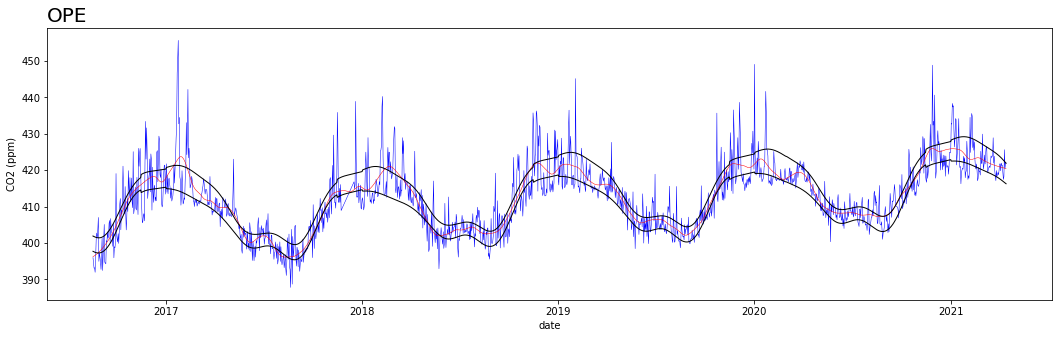

<Figure size 432x288 with 0 Axes>

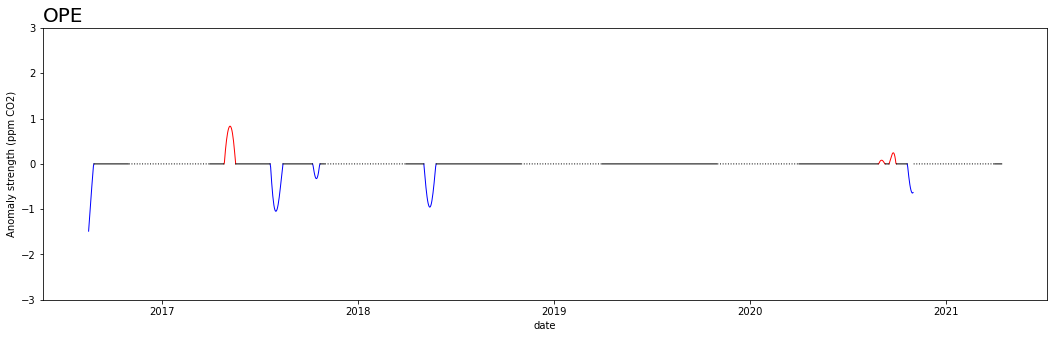

In [11]:
## Make plots 

# Plot raw data, smoothed data and envelope curves
plt.clf()
plt.figure(figsize=(18,5))
plt.title(st.stationId, loc='left', fontsize=20)
plt.xlabel('date')
plt.ylabel('CO2 (ppm)')
plt.plot(df_co2['dd'], df_co2['concentration'], linewidth=0.5, color='blue', label='daily data')
plt.plot(df_co2['dd'], df_co2['sm90'], linewidth=0.5, color='red', label='sm90')
plt.plot(df_co2['dd'], df_co2['+sd'], linewidth=1.0, color='black', label='')
plt.plot(df_co2['dd'], df_co2['-sd'], linewidth=1.0, color='black', label='')
plt.show()


# Plot anomalies
# Clean up blank dates
plot_clean(df_co2, '+SA', '-SA', 'no_anomaly')

# Show only growing season? (for seasonal-length anomalies)
show_summer_only = True
#show_summer_only = False

if bandwidth == 90:
    if bool(show_summer_only):
        df_co2['winter'] = ''
        for row in df_co2.iloc[1:nrow].itertuples():
            if ((df_co2.sampling_datetime.dt.month.iat[row.Index] >= 11) | 
               (df_co2.sampling_datetime.dt.month.iat[row.Index] <= 3)):
                df_co2['+SA'].iat[row.Index] = np.nan
                df_co2['-SA'].iat[row.Index] = np.nan
                df_co2['no_anomaly'].iat[row.Index] = np.nan
                df_co2.winter.iat[row.Index] = 0
        df_co2['winter'] = pd.to_numeric(df_co2['winter']) 

        
# Show only extended winter season? (for synoptic anomalies)
show_winter_only = True
#show_winter_only = False

if bandwidth == 30:
    if bool(show_winter_only):
        df_co2['summer'] = ''
        for row in df_co2.iloc[1:nrow].itertuples():
            if ((df_co2.sampling_datetime.dt.month.iat[row.Index] >= 4) & 
               (df_co2.sampling_datetime.dt.month.iat[row.Index] <= 10)):
                df_co2['+SA'].iat[row.Index] = np.nan
                df_co2['-SA'].iat[row.Index] = np.nan
                df_co2['no_anomaly'].iat[row.Index] = np.nan
                df_co2.summer.iat[row.Index] = 0
        df_co2['summer'] = pd.to_numeric(df_co2['summer']) 
 
plt.clf()
plt.figure(figsize=(18,5))
plt.title(st.stationId, loc='left', fontsize=20)
plt.xlabel('date')
plt.ylabel('Anomaly strength (ppm CO2)')
plt.plot(df_co2['dd'], df_co2['+SA'], linewidth=1.0, color='red', label='')
plt.plot(df_co2['dd'], df_co2['-SA'], linewidth=1.0, color='blue', label='')
plt.plot(df_co2['dd'], df_co2['no_anomaly'], linewidth=1.0, color='black', label='')
if bandwidth == 90:
    if bool(show_summer_only):
        plt.plot(df_co2['dd'], df_co2['winter'], linewidth=1.0, color='black', linestyle='dotted', label='')
if bandwidth == 30:
    if bool(show_winter_only):
        plt.plot(df_co2['dd'], df_co2['summer'], linewidth=1.0, color='black', linestyle='dotted', label='')

plt.ylim((-3, 3))
plt.show()